# 2CSSID Workshop02. Data preparation & Model evaluation

<p style='text-align: right;font-style: italic; color: red;'>Designed by: Mr. Abdelkrime Aries</p>


In [1]:
# Activate the lines to install unfound modules
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install imblearn

In [2]:
import numpy  as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.26.4', '2.2.2', '3.9.1')

In [3]:
import sqlite3
from imblearn.under_sampling import ClusterCentroids, TomekLinks
from imblearn.over_sampling import SMOTE

In [4]:
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree         import DecisionTreeClassifier
from sklearn.naive_bayes  import GaussianNB
from sklearn.ensemble     import RandomForestClassifier
from sklearn.metrics      import accuracy_score
from sklearn.metrics      import f1_score
import timeit

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## 1. Business understanding

1. One model having the 5 outputs (TWF, HDF, PWF, OSF, RNF) with softmax function.
    - ...
1. One model having the 5 outputs (TWF, HDF, PWF, OSF, RNF, Other) with softmax function.
    - ...
1. One model having the 5 outputs (TWF, HDF, PWF, OSF, RNF) with sigmoid function.
    - ...
1. One model having the 5 outputs (TWF, HDF, PWF, OSF, RNF, Other) with sigmoid function.
    - ...
1. Two models, one for binary classification for failure yes/no. In case of failure, we train a second model to detect the
type similar to that of first solution.
    - ...
1. the same thing, but the second model is similar to that of the third solution.
    - ...

## 2. Data understanding

### 2.1. Collecting initial data

In [6]:
#  Read ai4i2020a.csv
data1 = pd.read_csv('data/ai4i2020a.csv', delimiter=',')

data1.head()

,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
0,M0000A,M,NaN,NaN,1551.0,NaN,0.0,0,NOT
1,M14860,M,24.95,35.45,1551.0,42.8,0.0,0,NOT
2,L47181,L,25.05,35.55,1408.0,46.3,3.0,0,NOT
3,L47182,L,24.95,35.35,1498.0,49.4,5.0,0,NOT
4,L47183,L,25.05,35.45,1433.0,39.5,7.0,0,NOT


In [7]:
# Read ai4i2020b.sqlite
con = sqlite3.connect('data/ai4i2020b.sqlite')
data2 = pd.read_sql_query("SELECT * FROM failure", con)

#data2 = data2.replace('NA', np.nan)

#data2 = data2.fillna(np.nan)
data2 = data2.replace('', pd.NA)


#data2.head()
data2.iloc[740:747, :]

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF
740,M20599,302.2,<NA>,1653,<NA>,2,0,0,0,0,0,0
741,M20600,302.3,<NA>,1535,<NA>,5,0,0,0,0,0,0
742,M20601,302.3,<NA>,1483,40.5,<NA>,0,0,0,0,0,0
743,L52922,302.3,<NA>,1414,47.0,<NA>,0,0,0,0,0,0
744,M20603,302.2,311.6,<NA>,<NA>,13,0,0,0,0,0,0
745,H35158,302.2,311.5,<NA>,<NA>,16,0,0,0,0,0,0
746,L52925,302.1,311.5,<NA>,<NA>,21,0,0,0,0,0,0


### 2.2. Describing data

In [8]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               5983 non-null   object 
 1   Type                     5983 non-null   object 
 2   Air temperature [C]      5972 non-null   float64
 3   Process temperature [C]  5978 non-null   float64
 4   Rotational speed [rpm]   5978 non-null   float64
 5   Torque [Nm]              5982 non-null   float64
 6   Tool wear [min]          5980 non-null   float64
 7   Machine failure          5983 non-null   int64  
 8   Failure type             5983 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 420.8+ KB


In [9]:
data1['Rotational speed [rpm]'] = data1['Rotational speed [rpm]'].astype('Int64')
data1['Tool wear [min]'] = data1['Tool wear [min]'].astype('Int64')
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               5983 non-null   object 
 1   Type                     5983 non-null   object 
 2   Air temperature [C]      5972 non-null   float64
 3   Process temperature [C]  5978 non-null   float64
 4   Rotational speed [rpm]   5978 non-null   Int64  
 5   Torque [Nm]              5982 non-null   float64
 6   Tool wear [min]          5980 non-null   Int64  
 7   Machine failure          5983 non-null   int64  
 8   Failure type             5983 non-null   object 
dtypes: Int64(2), float64(3), int64(1), object(3)
memory usage: 432.5+ KB


In [10]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5019 entries, 0 to 5018
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    5019 non-null   object 
 1   Air_Temperature_K     5019 non-null   float64
 2   ProcessTemperature_K  5014 non-null   object 
 3   Rotational_speed      5016 non-null   object 
 4   Torque                5013 non-null   object 
 5   Tool_wear             5017 non-null   object 
 6   Failure               5019 non-null   int64  
 7   TWF                   5019 non-null   int64  
 8   HDF                   5019 non-null   int64  
 9   PWF                   5019 non-null   int64  
 10  OSF                   5019 non-null   int64  
 11  RNF                   5019 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 470.7+ KB


In [11]:
#data2['ProcessTemperature_K'] = data2['ProcessTemperature_K'].replace('', np.nan).astype(float)
#data2['Rotational_speed'] = data2['Rotational_speed'].replace('', np.nan).astype('Int64')
#data2['Tool_wear'] = data2['Tool_wear'].replace('', np.nan).astype('Int64')
data2['ProcessTemperature_K'] = data2['ProcessTemperature_K'].astype('Float64')
data2['Rotational_speed'] = data2['Rotational_speed'].astype('Int64')
data2['Tool_wear'] = data2['Tool_wear'].astype('Int64')
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5019 entries, 0 to 5018
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    5019 non-null   object 
 1   Air_Temperature_K     5019 non-null   float64
 2   ProcessTemperature_K  5014 non-null   Float64
 3   Rotational_speed      5016 non-null   Int64  
 4   Torque                5013 non-null   object 
 5   Tool_wear             5017 non-null   Int64  
 6   Failure               5019 non-null   int64  
 7   TWF                   5019 non-null   int64  
 8   HDF                   5019 non-null   int64  
 9   PWF                   5019 non-null   int64  
 10  OSF                   5019 non-null   int64  
 11  RNF                   5019 non-null   int64  
dtypes: Float64(1), Int64(2), float64(1), int64(6), object(2)
memory usage: 485.4+ KB


In [12]:
data1.describe()

,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
count,5972.000000,5978.000000,5978.0,5982.000000,5980.0,5983.000000
mean,27.165941,36.769036,1540.695718,39.883835,108.735452,0.039612
std,2.285344,1.666296,182.795413,9.899791,63.852593,0.195063
min,22.150000,32.550000,1168.0,3.800000,0.0,0.000000
25%,25.150000,35.450000,1423.0,33.200000,54.0,0.000000
50%,27.250000,36.550000,1504.0,40.000000,109.0,0.000000
75%,29.150000,37.950000,1613.0,46.700000,163.0,0.000000
max,31.350000,40.650000,2886.0,76.200000,251.0,1.000000


In [13]:
data2.describe()

,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF
count,5019.000000,5014.0,5016.0,5017.0,5019.000000,5019.000000,5019.000000,5019.000000,5019.000000,5019.000000
mean,299.188643,309.552333,1535.59051,107.365358,0.024308,0.005579,0.001793,0.009364,0.012154,0.002391
std,16.336889,16.388577,173.434366,63.381024,0.154018,0.074490,0.042312,0.096325,0.109583,0.048843
min,24.850000,35.55,1181.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,298.700000,309.6,1423.0,53.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,300.300000,310.6,1501.0,107.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,301.100000,311.5,1609.0,162.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,304.500000,313.8,2710.0,253.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
data1[data1['Type'] == 'L'].describe()

,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
count,3588.000000,3594.000000,3593.0,3595.000000,3594.0,3595.000000
mean,27.171433,36.767028,1541.608127,39.894214,109.676683,0.043672
std,2.266254,1.648043,186.036898,10.025461,64.124618,0.204392
min,22.150000,32.550000,1192.0,3.800000,0.0,0.000000
25%,25.150000,35.450000,1422.0,33.150000,55.0,0.000000
50%,27.150000,36.650000,1504.0,40.000000,111.0,0.000000
75%,29.150000,37.950000,1614.0,46.800000,164.0,0.000000
max,31.350000,40.650000,2886.0,71.600000,251.0,1.000000


### 2.3. Exploring data

[5746  237]


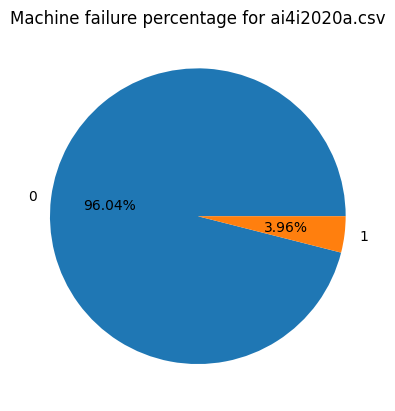

In [15]:
cls, freq = np.unique(data1['Machine failure'], return_counts=True)

print(freq)

plt.title('Machine failure percentage for ai4i2020a.csv')
plt.pie(freq, labels=cls, autopct='%1.2f%%')
plt.show()

[4897  122]


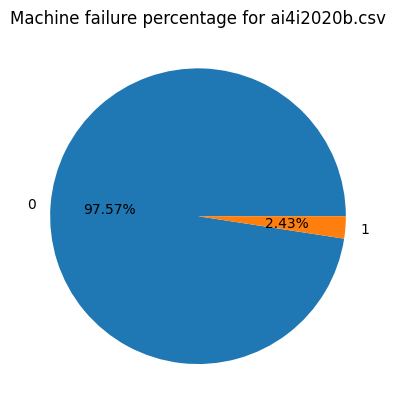

In [16]:
cls, freq = np.unique(data2['Failure'], return_counts=True)

print(freq)

plt.title('Machine failure percentage for ai4i2020b.csv')
plt.pie(freq, labels=cls, autopct='%1.2f%%')
plt.show()

['HDF' 'OSF' 'OTHER' 'PWF' 'TWF']


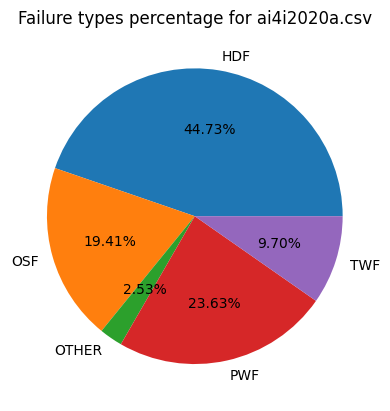

In [17]:
cls, freq = np.unique(data1[data1['Machine failure']==1]['Failure type'], return_counts=True)

print(cls)

plt.title('Failure types percentage for ai4i2020a.csv')
plt.pie(freq, labels=cls, autopct='%1.2f%%')
plt.show()

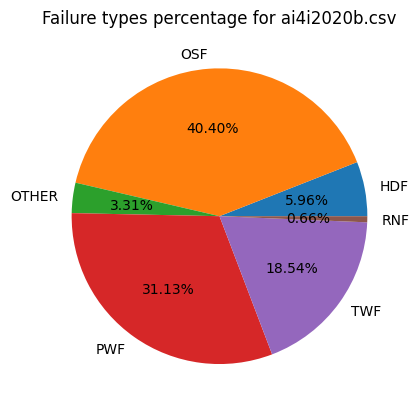

In [18]:
freq = []
other = data2['Failure']
cls2 = cls.tolist()
for c in cls2:
    if c != 'OTHER':
        freq.append((data2['Failure'] * data2[c]).sum())
        other = other * (1 - data2[c])

freq.insert(np.where(cls == 'OTHER')[0][0], other.sum())

cls2.append('RNF')
freq.append((data2['Failure'] * data2['RNF']).sum())


plt.title('Failure types percentage for ai4i2020b.csv')
plt.pie(freq, labels=cls2, autopct='%1.2f%%')
plt.show()

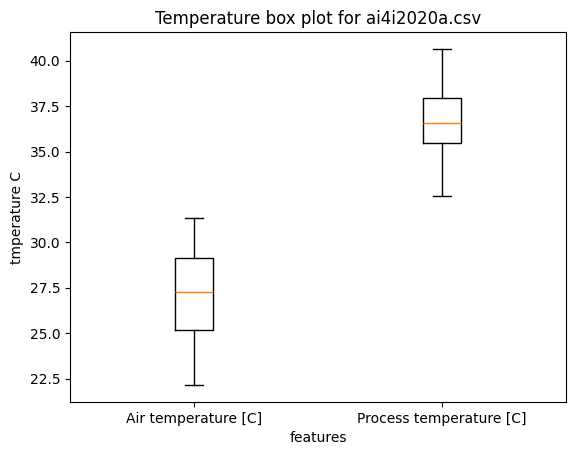

In [19]:
idx = data1[['Air temperature [C]', 'Process temperature [C]']].notnull()

plt.boxplot([
    data1['Air temperature [C]'].loc[idx['Air temperature [C]']],
    data1['Process temperature [C]'].loc[idx['Process temperature [C]']]
    ], tick_labels=['Air temperature [C]', 'Process temperature [C]'])
plt.title('Temperature box plot for ai4i2020a.csv')
plt.xlabel('features')
plt.ylabel('tmperature C')
plt.show()

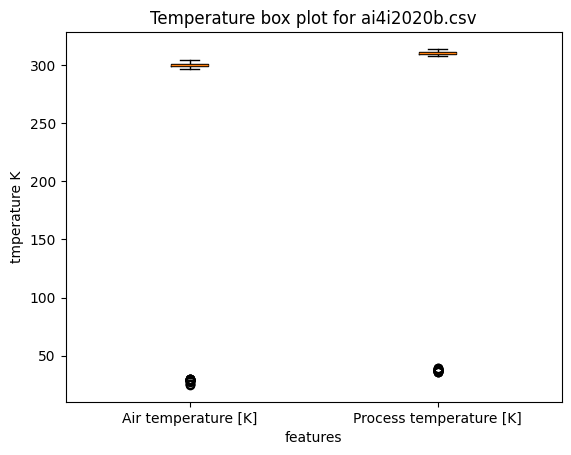

In [20]:
idx = data2[['Air_Temperature_K', 'ProcessTemperature_K']].notnull()

# print((1 - idx.astype(int)).sum())
# print(data2[['Air_Temperature_K', 'ProcessTemperature_K']].min())
# print(data2[['Air_Temperature_K', 'ProcessTemperature_K']].max())

plt.boxplot([
    data2['Air_Temperature_K'].loc[idx['Air_Temperature_K']],
    data2['ProcessTemperature_K'].loc[idx['ProcessTemperature_K']]
    ], tick_labels=['Air temperature [K]', 'Process temperature [K]'])
plt.title('Temperature box plot for ai4i2020b.csv')
plt.xlabel('features')
plt.ylabel('tmperature K')
plt.show()

In [21]:
# If you detect any outliers, display them.
data2[(data2['Air_Temperature_K'] < 100) | (data2['ProcessTemperature_K'] < 100)]

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF
5001,L47249,25.75,35.85,1410,65.7,191,1,0,0,1,1,0
5002,M16184,25.65,36.95,1243,74.5,194,1,0,0,1,1,0
5003,L48676,24.85,35.55,1268,69.4,189,1,0,0,1,1,0
5004,L50791,28.55,37.75,1405,46.4,207,1,1,0,0,0,1
5005,L51034,29.25,37.85,1338,67.6,194,1,0,0,1,1,0
5006,L51123,29.15,38.25,1333,66.7,205,1,0,0,1,1,0
5007,L51434,29.45,37.85,1284,68.0,114,1,0,1,1,0,0
5008,M19202,28.55,36.65,1284,68.2,111,1,0,1,1,0,0
5009,L51550,28.85,36.75,1308,57.6,197,1,0,1,0,1,0
5010,L51563,28.55,36.35,1298,65.5,229,1,0,1,0,1,0


(5968, 2)


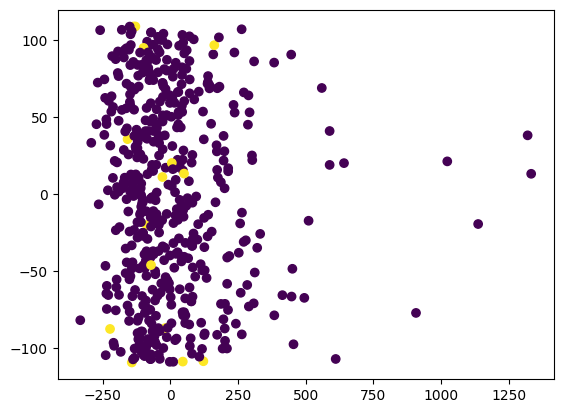

In [22]:
# Apply PCA on "Air temperature", "Process temperature", "Rotational speed", "Torque" and "Tool wear"
# to get a two dimensional representation.

# find samples in which all columns do not contain NA
idx = data1.iloc[:, 2:7].notna().all(axis=1)

data1nna = data1.iloc[data1[idx].index, 2:7]

pca2 = PCA(2)
data1_pca = pca2.fit_transform(data1nna)

print(data1_pca.shape)

plt.scatter(data1_pca[:500, 0], data1_pca[:500, 1], c=data1['Machine failure'].iloc[:500])

(5011, 2)


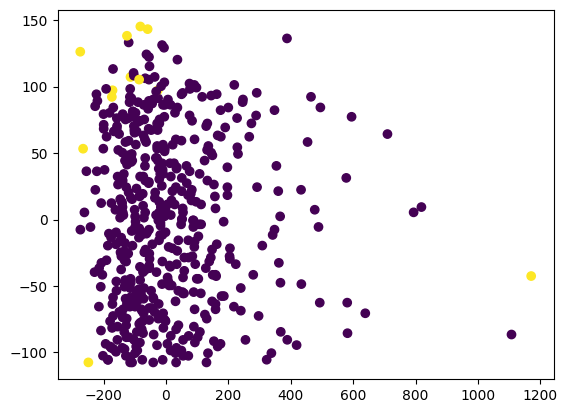

In [23]:
# find samples in which all columns do not contain NA
idx = data2.iloc[:, 1:6].notna().all(axis=1)

data2nna = data2.iloc[data2[idx].index, 1:6]

pca2 = PCA(2)
data2_pca = pca2.fit_transform(data2nna)

print(data2_pca.shape)

plt.scatter(data2_pca[:500, 0], data2_pca[:500, 1], c=data2['Failure'].iloc[:500])

### 2.4. Verifying data quality

In [24]:
data1[data1.isnull().any(axis=1)]

,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
0,M0000A,M,NaN,NaN,1551,NaN,0,0,NOT
1435,H30850,H,25.65,NaN,1510,44.2,35,0,NOT
2786,L49968,L,NaN,36.45,1326,52.4,57,0,NOT
2791,L49973,L,NaN,36.45,1597,31.8,73,0,NOT
2796,L49978,L,NaN,36.45,1568,39.6,85,0,NOT
2797,L49979,L,NaN,36.45,1404,44.6,87,0,NOT
2820,L50002,L,NaN,36.45,1593,38.1,140,0,NOT
5723,M20599,M,NaN,38.55,<NA>,31.4,2,0,NOT
5724,M20600,M,NaN,38.55,<NA>,38.3,5,0,NOT
5725,M20601,M,NaN,38.55,<NA>,40.5,8,0,NOT


In [25]:
data2[data2.isnull().any(axis=1)]

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF
740,M20599,302.2,<NA>,1653,<NA>,2,0,0,0,0,0,0
741,M20600,302.3,<NA>,1535,<NA>,5,0,0,0,0,0,0
742,M20601,302.3,<NA>,1483,40.5,<NA>,0,0,0,0,0,0
743,L52922,302.3,<NA>,1414,47.0,<NA>,0,0,0,0,0,0
744,M20603,302.2,311.6,<NA>,<NA>,13,0,0,0,0,0,0
745,H35158,302.2,311.5,<NA>,<NA>,16,0,0,0,0,0,0
746,L52925,302.1,311.5,<NA>,<NA>,21,0,0,0,0,0,0
942,L53121,300.6,<NA>,1438,<NA>,78,1,0,0,0,0,0


In [26]:
data1_inconst_idx = (data1['Machine failure'] == 0) & (data1['Failure type'] != 'NOT')
data1[data1_inconst_idx]

,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
1221,M16081,M,23.85,35.15,1399,46.4,132,0,RNF
1302,L48482,L,25.45,36.65,1505,45.7,144,0,RNF
1746,H31162,H,25.25,34.55,1626,31.1,166,0,RNF
2070,L49252,L,26.45,36.35,1570,35.5,189,0,RNF
2557,L49739,L,26.15,35.85,1447,50.4,140,0,RNF
3063,M17925,M,26.95,36.05,1687,27.7,95,0,RNF
3450,H32866,H,28.45,37.35,1602,32.3,2,0,RNF
5455,L52651,L,29.55,39.15,1346,61.2,170,0,RNF
5473,L52669,L,29.45,38.95,1499,35.0,215,0,RNF
5479,H34909,H,29.75,39.35,1357,55.0,12,0,RNF


In [27]:
# we do not need "other" in here
err = data2['HDF'] + data2['TWF'] + data2['PWF'] + data2['OSF'] + data2['RNF']
data2_inconst_idx = (data2['Failure'] == 0) & (err > 0)
data2[data2_inconst_idx]

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF
472,L52651,302.7,312.3,1346,61.2,170,0,0,0,0,0,1
490,L52669,302.6,312.1,1499,35.0,215,0,0,0,0,0,1
496,H34909,302.9,312.5,1357,55.0,12,0,0,0,0,0,1
510,L52689,302.8,312.2,1509,36.5,52,0,0,0,0,0,1
554,L52733,302.5,311.9,1306,59.7,172,0,0,0,0,0,1
640,L52819,302.6,312.1,1668,28.7,180,0,0,0,0,0,1
1092,L53271,300.9,310.7,1412,57.5,16,0,0,0,0,0,1
1914,L54093,300.8,311.2,1481,38.5,181,0,0,0,0,0,1
1961,L54140,300.7,311.0,1413,52.0,91,0,0,0,0,0,1
2489,L54668,300.3,311.7,1545,43.5,160,0,0,0,0,0,1


## 3. Data preparation

### 3.1. Selecting data

Do we need these features: "Product ID" and "Machine failure"? Why?
- "Product ID"?
    - Y|N
    - Why? ...
- "Machine failure"? 
    - Y|N 
    - Why? ...

### 3.2. Constructing new data 

In [28]:
# Transform Celsius into Kelvin for temperature : K = C + 273.15
data1['AirTemperature'] = data1['Air temperature [C]'] + 273.15
data1['ProcessTemperature'] = data1['Process temperature [C]'] + 273.15
data1.head()

,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type,AirTemperature,ProcessTemperature
0,M0000A,M,NaN,NaN,1551,NaN,0,0,NOT,NaN,NaN
1,M14860,M,24.95,35.45,1551,42.8,0,0,NOT,298.1,308.6
2,L47181,L,25.05,35.55,1408,46.3,3,0,NOT,298.2,308.7
3,L47182,L,24.95,35.35,1498,49.4,5,0,NOT,298.1,308.5
4,L47183,L,25.05,35.45,1433,39.5,7,0,NOT,298.2,308.6


In [29]:
# Transform Failure types into one categorical column and delete original columns (dataset 1)

data1 = pd.get_dummies(data1, columns=['Failure type'], dtype=int)

data1

,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,AirTemperature,ProcessTemperature,Failure type_HDF,Failure type_NOT,Failure type_OSF,Failure type_OTHER,Failure type_PWF,Failure type_RNF,Failure type_TWF
0,M0000A,M,NaN,NaN,1551,NaN,0,0,NaN,NaN,0,1,0,0,0,0,0
1,M14860,M,24.95,35.45,1551,42.8,0,0,298.1,308.6,0,1,0,0,0,0,0
2,L47181,L,25.05,35.55,1408,46.3,3,0,298.2,308.7,0,1,0,0,0,0,0
3,L47182,L,24.95,35.35,1498,49.4,5,0,298.1,308.5,0,1,0,0,0,0,0
4,L47183,L,25.05,35.45,1433,39.5,7,0,298.2,308.6,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978,L53175,L,27.45,37.15,1920,22.3,223,0,300.6,310.3,0,1,0,0,0,0,0
5979,M20856,M,27.35,37.05,1386,48.2,225,0,300.5,310.2,0,1,0,0,0,0,0
5980,M20857,M,27.35,37.05,1571,34.6,228,0,300.5,310.2,0,1,0,0,0,0,0
5981,M20858,M,27.25,37.05,1613,36.9,231,0,300.4,310.2,0,1,0,0,0,0,0


In [30]:
# Add another column for the failure type "OTHER" (dataset 2)

data2['OTHER'] = other

print(other.sum())

data2

5


,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF,OTHER
0,M19859,303.70,312.9,1532,41.3,32,0,0,0,0,0,0,0
1,L52180,303.70,312.8,1832,23.6,35,0,0,0,0,0,0,0
2,M19861,303.60,312.7,2174,17.6,37,0,0,0,0,0,0,0
3,L52182,303.70,312.8,1627,31.7,40,0,0,0,0,0,0,0
4,L52183,303.70,312.8,1437,51.3,42,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,L51823,30.05,38.25,1324,54.2,228,1,0,1,0,1,0,0
5015,L51909,30.25,38.65,1306,61.0,215,1,0,1,0,1,0,0
5016,M20254,29.65,39.15,1262,70.5,234,1,0,0,1,1,0,0
5017,M20261,29.45,39.15,1454,54.8,253,1,1,0,0,1,0,0


In [31]:
data1 = pd.get_dummies(data1, columns=['Type'], dtype=int)

data1

,Product ID,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,AirTemperature,ProcessTemperature,Failure type_HDF,Failure type_NOT,Failure type_OSF,Failure type_OTHER,Failure type_PWF,Failure type_RNF,Failure type_TWF,Type_H,Type_L,Type_M
0,M0000A,NaN,NaN,1551,NaN,0,0,NaN,NaN,0,1,0,0,0,0,0,0,0,1
1,M14860,24.95,35.45,1551,42.8,0,0,298.1,308.6,0,1,0,0,0,0,0,0,0,1
2,L47181,25.05,35.55,1408,46.3,3,0,298.2,308.7,0,1,0,0,0,0,0,0,1,0
3,L47182,24.95,35.35,1498,49.4,5,0,298.1,308.5,0,1,0,0,0,0,0,0,1,0
4,L47183,25.05,35.45,1433,39.5,7,0,298.2,308.6,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978,L53175,27.45,37.15,1920,22.3,223,0,300.6,310.3,0,1,0,0,0,0,0,0,1,0
5979,M20856,27.35,37.05,1386,48.2,225,0,300.5,310.2,0,1,0,0,0,0,0,0,0,1
5980,M20857,27.35,37.05,1571,34.6,228,0,300.5,310.2,0,1,0,0,0,0,0,0,0,1
5981,M20858,27.25,37.05,1613,36.9,231,0,300.4,310.2,0,1,0,0,0,0,0,0,0,1


In [32]:
# If "Type" does not exist, infer it from "Product ID"
# data2['Type'] = 'L'
# data2.loc[data2['ID'].str.startswith('M'), 'Type'] = 'M'
# data2.loc[data2['ID'].str.startswith('H'), 'Type'] = 'H'

# because Type  will be transformed into one-hot, let's do it directly
for t in ['L', 'H', 'M']:
    data2['Type_' + t] = np.where(data2['ID'].str.startswith(t), 1, 0)

data2

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF,OTHER,Type_L,Type_H,Type_M
0,M19859,303.70,312.9,1532,41.3,32,0,0,0,0,0,0,0,0,0,1
1,L52180,303.70,312.8,1832,23.6,35,0,0,0,0,0,0,0,1,0,0
2,M19861,303.60,312.7,2174,17.6,37,0,0,0,0,0,0,0,0,0,1
3,L52182,303.70,312.8,1627,31.7,40,0,0,0,0,0,0,0,1,0,0
4,L52183,303.70,312.8,1437,51.3,42,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,L51823,30.05,38.25,1324,54.2,228,1,0,1,0,1,0,0,1,0,0
5015,L51909,30.25,38.65,1306,61.0,215,1,0,1,0,1,0,0,1,0,0
5016,M20254,29.65,39.15,1262,70.5,234,1,0,0,1,1,0,0,0,0,1
5017,M20261,29.45,39.15,1454,54.8,253,1,1,0,0,1,0,0,0,0,1


### 3.3. Integrating data

In [33]:
# Rename columns to get the same schema.
d1_names = {
    'Product ID': 'ID',
    'Rotational speed [rpm]': 'RotationalSpeed',
    'Torque [Nm]': 'Torque',
    'Tool wear [min]': 'ToolWear',
    'Machine failure': 'Failure',
    'Failure type_HDF': 'HDF',
    'Failure type_OSF': 'OSF',
    'Failure type_OTHER': 'OTHER',
    'Failure type_PWF': 'PWF',
    'Failure type_RNF': 'RNF',
    'Failure type_TWF': 'TWF'
}

data1.rename(columns=d1_names, inplace=True)

data1

,ID,Air temperature [C],Process temperature [C],RotationalSpeed,Torque,ToolWear,Failure,AirTemperature,ProcessTemperature,HDF,Failure type_NOT,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M
0,M0000A,NaN,NaN,1551,NaN,0,0,NaN,NaN,0,1,0,0,0,0,0,0,0,1
1,M14860,24.95,35.45,1551,42.8,0,0,298.1,308.6,0,1,0,0,0,0,0,0,0,1
2,L47181,25.05,35.55,1408,46.3,3,0,298.2,308.7,0,1,0,0,0,0,0,0,1,0
3,L47182,24.95,35.35,1498,49.4,5,0,298.1,308.5,0,1,0,0,0,0,0,0,1,0
4,L47183,25.05,35.45,1433,39.5,7,0,298.2,308.6,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978,L53175,27.45,37.15,1920,22.3,223,0,300.6,310.3,0,1,0,0,0,0,0,0,1,0
5979,M20856,27.35,37.05,1386,48.2,225,0,300.5,310.2,0,1,0,0,0,0,0,0,0,1
5980,M20857,27.35,37.05,1571,34.6,228,0,300.5,310.2,0,1,0,0,0,0,0,0,0,1
5981,M20858,27.25,37.05,1613,36.9,231,0,300.4,310.2,0,1,0,0,0,0,0,0,0,1


In [34]:
# Rename columns to get the same schema.
d2_names = {
	'Air_Temperature_K': 'AirTemperature',
    'ProcessTemperature_K': 'ProcessTemperature',
    'Rotational_speed': 'RotationalSpeed',
    'Tool_wear': 'ToolWear'
}

data2.rename(columns=d2_names, inplace=True)

data2

,ID,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,Failure,TWF,HDF,PWF,OSF,RNF,OTHER,Type_L,Type_H,Type_M
0,M19859,303.70,312.9,1532,41.3,32,0,0,0,0,0,0,0,0,0,1
1,L52180,303.70,312.8,1832,23.6,35,0,0,0,0,0,0,0,1,0,0
2,M19861,303.60,312.7,2174,17.6,37,0,0,0,0,0,0,0,0,0,1
3,L52182,303.70,312.8,1627,31.7,40,0,0,0,0,0,0,0,1,0,0
4,L52183,303.70,312.8,1437,51.3,42,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,L51823,30.05,38.25,1324,54.2,228,1,0,1,0,1,0,0,1,0,0
5015,L51909,30.25,38.65,1306,61.0,215,1,0,1,0,1,0,0,1,0,0
5016,M20254,29.65,39.15,1262,70.5,234,1,0,0,1,1,0,0,0,0,1
5017,M20261,29.45,39.15,1454,54.8,253,1,1,0,0,1,0,0,0,0,1


In [35]:
# Delete unshared columns (which exists only in one dataset).
data1.drop(['Air temperature [C]', 'Process temperature [C]', 'Failure type_NOT'], axis=1, inplace=True)
data1

,ID,RotationalSpeed,Torque,ToolWear,Failure,AirTemperature,ProcessTemperature,HDF,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M
0,M0000A,1551,NaN,0,0,NaN,NaN,0,0,0,0,0,0,0,0,1
1,M14860,1551,42.8,0,0,298.1,308.6,0,0,0,0,0,0,0,0,1
2,L47181,1408,46.3,3,0,298.2,308.7,0,0,0,0,0,0,0,1,0
3,L47182,1498,49.4,5,0,298.1,308.5,0,0,0,0,0,0,0,1,0
4,L47183,1433,39.5,7,0,298.2,308.6,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978,L53175,1920,22.3,223,0,300.6,310.3,0,0,0,0,0,0,0,1,0
5979,M20856,1386,48.2,225,0,300.5,310.2,0,0,0,0,0,0,0,0,1
5980,M20857,1571,34.6,228,0,300.5,310.2,0,0,0,0,0,0,0,0,1
5981,M20858,1613,36.9,231,0,300.4,310.2,0,0,0,0,0,0,0,0,1


In [36]:
# Merge the two tables into one.

data = pd.concat([data1, data2])

data

,ID,RotationalSpeed,Torque,ToolWear,Failure,AirTemperature,ProcessTemperature,HDF,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M
0,M0000A,1551,NaN,0,0,NaN,<NA>,0,0,0,0,0,0,0,0,1
1,M14860,1551,42.8,0,0,298.10,308.6,0,0,0,0,0,0,0,0,1
2,L47181,1408,46.3,3,0,298.20,308.7,0,0,0,0,0,0,0,1,0
3,L47182,1498,49.4,5,0,298.10,308.5,0,0,0,0,0,0,0,1,0
4,L47183,1433,39.5,7,0,298.20,308.6,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,L51823,1324,54.2,228,1,30.05,38.25,1,1,0,0,0,0,0,1,0
5015,L51909,1306,61.0,215,1,30.25,38.65,1,1,0,0,0,0,0,1,0
5016,M20254,1262,70.5,234,1,29.65,39.15,0,1,0,1,0,0,0,0,1
5017,M20261,1454,54.8,253,1,29.45,39.15,0,1,0,0,0,1,0,0,1


### 3.4. Cleaning data

In [37]:
# Delete all inconsistent samples (there is no failure yet there is a failure type)
err = data['HDF'] + data['TWF'] + data['PWF'] + data['OSF'] + data['RNF'] + data['OTHER']
data_inconst_idx = (data['Failure'] == 0) & (err > 0)

data[data_inconst_idx]

,ID,RotationalSpeed,Torque,ToolWear,Failure,AirTemperature,ProcessTemperature,HDF,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M
1221,M16081,1399,46.4,132,0,297.0,308.3,0,0,0,0,1,0,0,0,1
1302,L48482,1505,45.7,144,0,298.6,309.8,0,0,0,0,1,0,0,1,0
1746,H31162,1626,31.1,166,0,298.4,307.7,0,0,0,0,1,0,1,0,0
2070,L49252,1570,35.5,189,0,299.6,309.5,0,0,0,0,1,0,0,1,0
2557,L49739,1447,50.4,140,0,299.3,309.0,0,0,0,0,1,0,0,1,0
3063,M17925,1687,27.7,95,0,300.1,309.2,0,0,0,0,1,0,0,0,1
3450,H32866,1602,32.3,2,0,301.6,310.5,0,0,0,0,1,0,1,0,0
5455,L52651,1346,61.2,170,0,302.7,312.3,0,0,0,0,1,0,0,1,0
5473,L52669,1499,35.0,215,0,302.6,312.1,0,0,0,0,1,0,0,1,0
5479,H34909,1357,55.0,12,0,302.9,312.5,0,0,0,0,1,0,1,0,0


In [38]:
data.drop(data[data_inconst_idx].index, axis=0, inplace=True)

# test again
err = data['HDF'] + data['TWF'] + data['PWF'] + data['OSF'] + data['RNF'] + data['OTHER']
data_inconst_idx = (data['Failure'] == 0) & (err > 0)

data[data_inconst_idx]


,ID,RotationalSpeed,Torque,ToolWear,Failure,AirTemperature,ProcessTemperature,HDF,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M


In [39]:
# Find all duplicate samples using "product ID"
dup = data[data.duplicated('ID', keep=False)]
dup

,ID,RotationalSpeed,Torque,ToolWear,Failure,AirTemperature,ProcessTemperature,HDF,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M
4985,M19859,1532,41.3,32,0,303.70,312.9,0,0,0,0,0,0,0,0,1
4986,L52180,1832,23.6,35,0,303.70,312.8,0,0,0,0,0,0,0,1,0
4987,M19861,2174,17.6,37,0,303.60,312.7,0,0,0,0,0,0,0,0,1
4988,L52182,1627,31.7,40,0,303.70,312.8,0,0,0,0,0,0,0,1,0
4989,L52183,1437,51.3,42,0,303.70,312.8,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,M20858,1613,36.9,231,0,300.40,310.2,0,0,0,0,0,0,0,0,1
1000,M20859,1671,30.5,234,1,300.40,310.2,0,0,0,0,0,1,0,0,1
5016,M20254,1262,70.5,234,1,29.65,39.15,0,1,0,1,0,0,0,0,1
5017,M20261,1454,54.8,253,1,29.45,39.15,0,1,0,0,0,1,0,0,1


In [40]:
dup.isna().sum()

ID                    0
RotationalSpeed       8
Torque                6
ToolWear              5
Failure               0
AirTemperature        5
ProcessTemperature    8
HDF                   0
OSF                   0
OTHER                 0
PWF                   0
RNF                   0
TWF                   0
Type_H                0
Type_L                0
Type_M                0
dtype: int64

In [41]:
# Replace all missing values from the same product (using "product ID")
# data = data.groupby('ID').ffill()
# data = data.groupby('ID').bfill()
data.update(data.groupby('ID').ffill())
data.update(data.groupby('ID').bfill())

# verify again
dup = data[data.duplicated('ID', keep=False)]
dup.isna().sum()

ID                    0
RotationalSpeed       0
Torque                0
ToolWear              0
Failure               0
AirTemperature        0
ProcessTemperature    0
HDF                   0
OSF                   0
OTHER                 0
PWF                   0
RNF                   0
TWF                   0
Type_H                0
Type_L                0
Type_M                0
dtype: int64

In [42]:
# Delete duplicates
data.drop_duplicates('ID', keep='last', inplace=True)

# test
data[data.duplicated('ID', keep=False)]

,ID,RotationalSpeed,Torque,ToolWear,Failure,AirTemperature,ProcessTemperature,HDF,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M


In [43]:
# Create a "NOT" column for not failure.
data['NOT'] = 1 - data['Failure']
data

,ID,RotationalSpeed,Torque,ToolWear,Failure,AirTemperature,ProcessTemperature,HDF,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M,NOT
0,M0000A,1551,NaN,0,0,NaN,<NA>,0,0,0,0,0,0,0,0,1,1
1,M14860,1551,42.8,0,0,298.10,308.6,0,0,0,0,0,0,0,0,1,1
2,L47181,1408,46.3,3,0,298.20,308.7,0,0,0,0,0,0,0,1,0,1
3,L47182,1498,49.4,5,0,298.10,308.5,0,0,0,0,0,0,0,1,0,1
4,L47183,1433,39.5,7,0,298.20,308.6,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,L51823,1324,54.2,228,1,30.05,38.25,1,1,0,0,0,0,0,1,0,0
5015,L51909,1306,61.0,215,1,30.25,38.65,1,1,0,0,0,0,0,1,0,0
5016,M20254,1262,70.5,234,1,29.65,39.15,0,1,0,1,0,0,0,0,1,0
5017,M20261,1454,54.8,253,1,29.45,39.15,0,1,0,0,0,1,0,0,1,0


In [44]:
# Delete "Product ID" and "Failure" (no need for those anymore)
data.drop(['ID', 'Failure'], axis=1, inplace=True)
data

,RotationalSpeed,Torque,ToolWear,AirTemperature,ProcessTemperature,HDF,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M,NOT
0,1551,NaN,0,NaN,<NA>,0,0,0,0,0,0,0,0,1,1
1,1551,42.8,0,298.10,308.6,0,0,0,0,0,0,0,0,1,1
2,1408,46.3,3,298.20,308.7,0,0,0,0,0,0,0,1,0,1
3,1498,49.4,5,298.10,308.5,0,0,0,0,0,0,0,1,0,1
4,1433,39.5,7,298.20,308.6,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,1324,54.2,228,30.05,38.25,1,1,0,0,0,0,0,1,0,0
5015,1306,61.0,215,30.25,38.65,1,1,0,0,0,0,0,1,0,0
5016,1262,70.5,234,29.65,39.15,0,1,0,1,0,0,0,0,1,0
5017,1454,54.8,253,29.45,39.15,0,1,0,0,0,1,0,0,1,0


In [45]:
# If a sample has more than a missing value, delete it
idx_na2 = data.isna().sum(axis=1) > 1
print('number of samples ith more than one missing value (before)', idx_na2.sum())

data.drop(data[idx_na2].index, axis=0, inplace=True)

# If a sample has more than a missing value, delete it
idx_na2 = data.isna().sum(axis=1) > 1
print('number of samples ith more than one missing value (after)', idx_na2.sum())

number of samples ith more than one missing value (before) 1
number of samples ith more than one missing value (after) 0


In [46]:
# check the features wich has null values
data.isna().sum(axis=0)

RotationalSpeed       0
Torque                0
ToolWear              0
AirTemperature        5
ProcessTemperature    1
HDF                   0
OSF                   0
OTHER                 0
PWF                   0
RNF                   0
TWF                   0
Type_H                0
Type_L                0
Type_M                0
NOT                   0
dtype: int64

In [47]:
# Replace missing values by the average of the same type
mn_rp = lambda x: x.fillna(x.mean())
data['AirTemperature'] = data.groupby(['Type_H', 'Type_L', 'Type_M'])['AirTemperature'].transform(mn_rp)
data['ProcessTemperature'] = data.groupby(['Type_H', 'Type_L', 'Type_M'])['ProcessTemperature'].transform(mn_rp)

# check the features wich has null values
data.isna().sum(axis=0)

RotationalSpeed       0
Torque                0
ToolWear              0
AirTemperature        0
ProcessTemperature    0
HDF                   0
OSF                   0
OTHER                 0
PWF                   0
RNF                   0
TWF                   0
Type_H                0
Type_L                0
Type_M                0
NOT                   0
dtype: int64

### 3.5. Formatting data and Constructing new data

In [48]:
# If a class has less than 10 samples, consider it as "OTHER".

cls = ['HDF', 'OSF', 'PWF', 'RNF', 'TWF']
drp = []
for c in cls: 
    nbr = data[c].sum()
    print(c, nbr)
    if nbr < 10:
        data['OTHER'] = ((data['OTHER'] + data[c]) > 0).astype(int)
        drp.append(c)
data.drop(drp, axis=1, inplace=True)

data

HDF 115
OSF 98
PWF 95
RNF 1
TWF 46


,RotationalSpeed,Torque,ToolWear,AirTemperature,ProcessTemperature,HDF,OSF,OTHER,PWF,TWF,Type_H,Type_L,Type_M,NOT
1,1551,42.8,0,298.10,308.6,0,0,0,0,0,0,0,1,1
2,1408,46.3,3,298.20,308.7,0,0,0,0,0,0,1,0,1
3,1498,49.4,5,298.10,308.5,0,0,0,0,0,0,1,0,1
4,1433,39.5,7,298.20,308.6,0,0,0,0,0,0,1,0,1
5,1408,40.0,9,298.20,308.7,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,1324,54.2,228,30.05,38.25,1,1,0,0,0,0,1,0,0
5015,1306,61.0,215,30.25,38.65,1,1,0,0,0,0,1,0,0
5016,1262,70.5,234,29.65,39.15,0,1,0,1,0,0,0,1,0
5017,1454,54.8,253,29.45,39.15,0,1,0,0,1,0,0,1,0


In [49]:
# Put the classes at the end so we can select them easily.
idx = ['RotationalSpeed', 'Torque','ToolWear', 'AirTemperature', 'ProcessTemperature',
'Type_H', 'Type_L', 'Type_M',
'HDF', 'OSF', 'OTHER', 'PWF', 'TWF', 'NOT']

data = data.reindex(idx, axis=1)

data

,RotationalSpeed,Torque,ToolWear,AirTemperature,ProcessTemperature,Type_H,Type_L,Type_M,HDF,OSF,OTHER,PWF,TWF,NOT
1,1551,42.8,0,298.10,308.6,0,0,1,0,0,0,0,0,1
2,1408,46.3,3,298.20,308.7,0,1,0,0,0,0,0,0,1
3,1498,49.4,5,298.10,308.5,0,1,0,0,0,0,0,0,1
4,1433,39.5,7,298.20,308.6,0,1,0,0,0,0,0,0,1
5,1408,40.0,9,298.20,308.7,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,1324,54.2,228,30.05,38.25,0,1,0,1,1,0,0,0,0
5015,1306,61.0,215,30.25,38.65,0,1,0,1,1,0,0,0,0
5016,1262,70.5,234,29.65,39.15,0,0,1,0,1,0,1,0,0
5017,1454,54.8,253,29.45,39.15,0,0,1,0,1,0,0,1,0


In [50]:
# split into input and output
X = data.iloc[:, :-6].to_numpy()
Y = data.iloc[:, -6:].to_numpy()

X.shape, Y.shape

((9963, 8), (9963, 6))

In [51]:
Y.sum(axis=0)

array([ 115,   98,   10,   95,   46, 9624])

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

l = Y_test.shape[1]


X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((6974, 8), (2989, 8), (6974, 6), (2989, 6))

In [53]:
nbr_cls = Y_train.sum(axis=0)
nbr_cls

array([  86,   70,    7,   63,   33, 6732])

In [54]:
# (since sampling cannot work with multilabel classes, so try to convert it to a multiclass problem: combination of all classes)
def bin2cls(tab):
    p = 1
    r = 0
    for t in tab:
        r += t * p
        p *= 2
    return r

# = 1*2^0 + 0*2^1 + 0*2^2 + 1*2^3 + 0*2^4 + 0*2^5 + 1*2^6
# = 1 + 0 + 0 + 8 + 0 + 0 + 64
bin2cls([1, 0, 0, 1, 0, 0, 1])

73

In [55]:
# Implement the revert function.
def cls2bin(n, l=l):
    r = []
    p = 2
    while n:
        n, m = divmod(n, p)
        r = [m] + r
    if len(r) < l:
        r = r + ([0] * (l - len(r)))
    return r

cls2bin(73, l=7)

[1, 0, 0, 1, 0, 0, 1]

In [56]:
YY = np.array(list(map(bin2cls, Y_train)))
ncls, count  = np.unique(YY, return_counts=True)
ncls, count

(array([ 1,  2,  3,  4,  8,  9, 10, 16, 18, 20, 32]),
 array([  78,   57,    5,    6,   53,    3,    7,   31,    1,    1, 6732]))

In [57]:
# classes with more than 10 samples
ncls10 = ncls[count>10]
ncls10

array([ 1,  2,  8, 16, 32])

In [58]:
# samples ith those classes
idx10 = np.isin(YY, ncls10)

idx10.shape, YY.shape

((6974,), (6974,))

In [59]:
# Apply the oversampling SMOTE on training dataset to get a new one
# (on the classes with more than 10 samples).

X_smote, Y_smote = SMOTE().fit_resample(X_train[idx10, :], YY[idx10])

X_smote.shape, Y_smote.shape

((33660, 8), (33660,))

In [60]:
# add the other classes
X_smote = np.concatenate([X_smote, X_train[~idx10, :]], axis=0)
Y_smote = np.concatenate([Y_smote, YY[~idx10]], axis=0)
X_smote.shape, Y_smote.shape

((33683, 8), (33683,))

In [61]:
Y_smote = np.array(list(map(cls2bin, Y_smote)))
Y_smote.shape

(33683, 6)

In [62]:
# Apply two undersampling techniques on the majority
# class: ClusterCentroids

# the majority class (c=32) having 6732 samples will have 200 samples
X_cc, Y_cc = ClusterCentroids(sampling_strategy={32: 200}).fit_resample(X_train[idx10, :], YY[idx10])
X_cc.shape, Y_cc.shape

((419, 8), (419,))

In [63]:
# add the other classes
X_cc = np.concatenate([X_cc, X_train[~idx10, :]], axis=0)
Y_cc = np.concatenate([Y_cc, YY[~idx10]], axis=0)
X_cc.shape, Y_cc.shape

((442, 8), (442,))

In [64]:
Y_cc = np.array(list(map(cls2bin, Y_cc)))
Y_cc.shape

(442, 6)

In [65]:
# Apply two undersampling techniques on the majority
# class: TomekLinks

# the majority class (c=32) 
X_tl, Y_tl = TomekLinks(sampling_strategy=[32]).fit_resample(X_train[idx10, :], YY[idx10])
X_tl.shape, Y_tl.shape

((6879, 8), (6879,))

In [66]:
# add the other classes
X_tl = np.concatenate([X_tl, X_train[~idx10, :]], axis=0)
Y_tl = np.concatenate([Y_tl, YY[~idx10]], axis=0)
X_tl.shape, Y_tl.shape

((6902, 8), (6902,))

In [67]:
Y_tl = np.array(list(map(cls2bin, Y_tl)))
Y_tl.shape

(6902, 6)

In [68]:
# Apply normalization on the 4 past datasets to get three new ones.
# In this case, we will have 8 training datasets: 
# No\_sampling, No\_sampling\_normalized, SMOTE, SMOTE\_normalized, ClusterCentroids, 
# ClusterCentroids\_normalized, TomekLinks and TomekLinks\_normalized.

plain_norm = StandardScaler()
smote_norm = StandardScaler()
cc_norm = StandardScaler()
tl_norm = StandardScaler()

X_train_norm = plain_norm.fit_transform(X_train)
X_train_smote_norm = smote_norm.fit_transform(X_smote)
X_train_cc_norm = cc_norm.fit_transform(X_cc)
X_train_tl_norm = tl_norm.fit_transform(X_tl)

X_train_norm[0, :], X_train_smote_norm[0, :], X_train_cc_norm[0, :], X_train_tl_norm[0, :]

(array([ 0.44702912, -0.7219019 ,  0.79843263,  0.27265289,  0.22392071,
        -0.33136486, -1.23490157,  1.53812552]),
 array([ 0.39083419, -1.00639304,  0.18215067,  0.40501048,  0.37302608,
        -0.33738726, -1.584314  ,  1.93402461]),
 array([-0.64732179,  0.37367319,  0.26133482,  0.22305535,  0.18154518,
        -0.41596116,  0.9832689 , -0.82201525]),
 array([ 0.44568346, -0.71695607,  0.80421728,  0.27221687,  0.2237523 ,
        -0.3305898 , -1.2377055 ,  1.54058805]))

In [69]:
# Apply the same normalization on test dataset to get 4 test datasets

X_test_norm = plain_norm.transform(X_test)
X_test_smote_norm = smote_norm.transform(X_test)
X_test_cc_norm = cc_norm.transform(X_test)
X_test_tl_norm = tl_norm.transform(X_test)

X_test_norm[0, :], X_test_smote_norm[0, :], X_test_cc_norm[0, :], X_test_tl_norm[0, :]

(array([-1.05870152,  0.40405241,  1.536012  ,  0.04501643,  0.14250603,
        -0.33136486,  0.80978114, -0.650142  ]),
 array([-0.46108188, -0.24562392,  0.85534639, -0.07430041,  0.19737273,
        -0.33738726,  0.80861999, -0.67698277]),
 array([-0.57886172, -0.04433572,  1.08325741,  0.17053575,  0.20248891,
        -0.41596116,  0.9832689 , -0.82201525]),
 array([-1.07565274,  0.41690219,  1.54343926,  0.04572788,  0.14275015,
        -0.3305898 ,  0.80794664, -0.64910279]))

## 4. Modeling and Evaluation

In [70]:
def multilabe_model_train_test(mdls, xtrain, xtest, ytrain, ytest):
    r = []
    t = timeit.default_timer()
    for i in range(l):
        mdls[i].fit(xtrain, ytrain[:, i])
    t = timeit.default_timer() - t
    r.append(t)

    tt = 0.
    aa = 0.
    for i in range(l):
        t = timeit.default_timer()
        ys = mdls[i].predict(xtest)
        tt += timeit.default_timer() - t
        aa += accuracy_score(ytest[:, i], ys)

    r.append(tt)

    a = 0.
    for i in range(l):
        a += accuracy_score(ytrain[:, i], mdls[i].predict(xtrain))
    
    r.append(a/l)
    r.append(aa/l)
    return r

In [71]:
# Logistic regression with L2 penalization (by default) and "liblinear" solver.
results = {
    'Metrics': ['Train time', 'Test time', 'Train Accuracy', 'Test Accuracy']
}

datasets = [
    ('plain', X_train, X_test, Y_train, Y_test),
    ('plain-norm', X_train_norm, X_test_norm, Y_train, Y_test),
    ('smote', X_smote, X_test, Y_smote, Y_test),
    ('smote-norm', X_train_smote_norm, X_test_norm, Y_smote, Y_test),
    ('cc', X_cc, X_test, Y_cc, Y_test),
    ('cc-norm', X_train_cc_norm, X_test_norm, Y_cc, Y_test),
    ('tl', X_tl, X_test, Y_tl, Y_test),
    ('tl-norm', X_train_tl_norm, X_test_norm, Y_tl, Y_test),
]

for name, xtrain, xtest, ytrain, ytest in datasets:
    results['LR-' + name] = multilabe_model_train_test(
        [LogisticRegression(solver='liblinear') for _ in range(l)], X_train, X_test, Y_train, Y_test
    )
    results['GNB-' + name] = multilabe_model_train_test(
        [GaussianNB() for _ in range(l)], X_train, X_test, Y_train, Y_test
    )
    results['CART-' + name] = multilabe_model_train_test(
        [DecisionTreeClassifier() for _ in range(l)], X_train, X_test, Y_train, Y_test
    )
    results['RF-' + name] = multilabe_model_train_test(
        [RandomForestClassifier(n_estimators=50) for _ in range(l)], X_train, X_test, Y_train, Y_test
    )

pd.DataFrame(results).transpose()

,0,1,2,3
Metrics,Train time,Test time,Train Accuracy,Test Accuracy
LR-plain,0.066442,0.004673,0.989485,0.990632
GNB-plain,0.024289,0.008957,0.988003,0.989629
CART-plain,0.069333,0.003889,1.0,0.992417
RF-plain,0.67658,0.027753,0.999952,0.993643
LR-plain-norm,0.062447,0.005132,0.989485,0.990632
GNB-plain-norm,0.02422,0.008849,0.988003,0.989629
CART-plain-norm,0.068786,0.003949,1.0,0.992417
RF-plain-norm,0.677563,0.028234,0.999904,0.993699
LR-smote,0.060546,0.005774,0.989485,0.990632
